# NLP-Based Skin Disease Classification

## By: [Tahsin Jahin Khalid](https://tahsinjahinkhalid.github.io/)

### Import Essential Modules

In [310]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [311]:
%matplotlib inline

In [312]:
warnings.filterwarnings('ignore')

In [313]:
from functionModule.text_preprocess import preprocess_text
from functionModule.generate_wordcloud import generate_wordcloud

In [314]:
import plotly.express as px
import spacy

In [315]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

In [316]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier

In [317]:
# create a processing pipeline
nlp = spacy.load('en_core_web_lg')

In [318]:
# check the component in the processing pipeline
print('Components in the processing pipeline: ', nlp.pipe_names)

Components in the processing pipeline:  ['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']


### Load Data

In [319]:
data_text = pl.read_csv("data/data.csv", 
                        separator=",", quote_char='"',
                        has_header=True, 
                        columns=["Disease name", "Text"],
                        new_columns=["disease", "text"])

In [320]:
data_text.head(5)

disease,text
str,str
"""Vitiligo""","""""I've had thes…"
"""Scabies""","""""Doctor, I've …"
"""Vitiligo""","""""Doctor, I not…"
"""Hives (Urticar…","""Hives, also kn…"
"""Folliculitis""","""""I have these …"


### Data Frame Info

In [321]:
num_rows, num_cols = data_text.shape
print(f"There are {num_rows} rows and {num_cols} columns")

There are 143 rows and 2 columns


In [322]:
data_text.schema

OrderedDict([('disease', String), ('text', String)])

Checking for Null Values

In [323]:
data_text.to_pandas().isnull().sum()

disease    0
text       0
dtype: int64

Check for Duplicates

In [324]:
data_text.is_duplicated().sum()

5

In [325]:
data_text.filter(
    data_text.is_duplicated()
)

disease,text
str,str
"""Contact Dermat…",""" ""My hands are…"
"""Contact Dermat…",""" ""My hands are…"
"""Contact Dermat…",""" ""My hands are…"
"""Contact Dermat…",""" ""My hands are…"
"""Contact Dermat…",""" ""My hands are…"


In [326]:
# data_text_distinct = data_text.unique()
data_text2 = data_text.clone()

### Preprocessing Text

In [327]:
data_text2= data_text2.with_columns(
    data_text2['disease'] \
        .apply(lambda x: x.lower()) \
            .alias('disease'))

In [328]:
data_text2 = data_text2.with_columns(
    data_text2['text'] \
    .apply(preprocess_text).alias('text')
)

In [329]:
data_text2.head(5)

disease,text
str,str
"""vitiligo""","""ive light patc…"
"""scabies""","""doctor ive not…"
"""vitiligo""","""doctor noticed…"
"""hives (urticar…","""hive also know…"
"""folliculitis""","""small hard bum…"


In [330]:
# plot a treemap chart using plotly express
fig = px.treemap(
    data_text2, 
    path=[px.Constant('all'), 'disease'], 
    title='Proportion of Diseases')
fig.update_traces(root_color='lightgrey')

# set the plot layout
fig.update_layout(width=900, height=700, 
                  margin = dict(t=50, l=25, r=25, b=25))

# display the plot
fig.show()

### Word Clouds

#### Vitiligo: Keywords

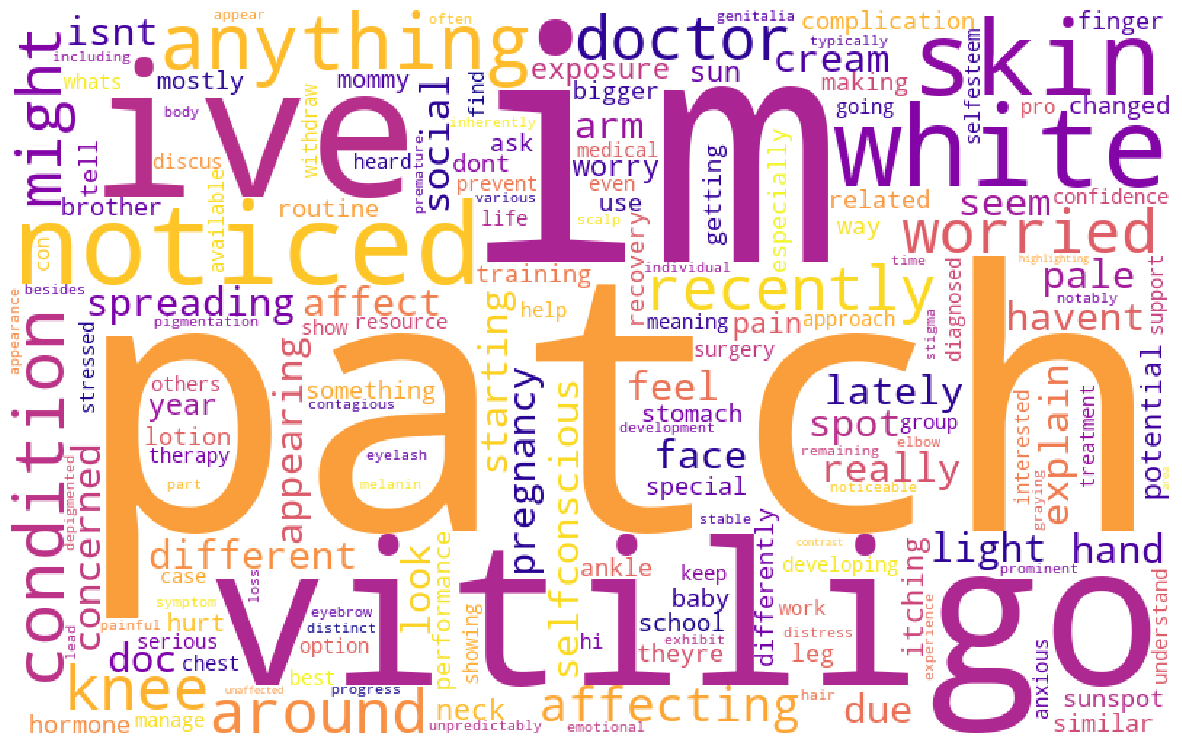

In [331]:
vitiligo = data_text2.filter(pl.col('disease') == 'vitiligo')
generate_wordcloud(vitiligo, 'text')

#### Scabies: Keywords

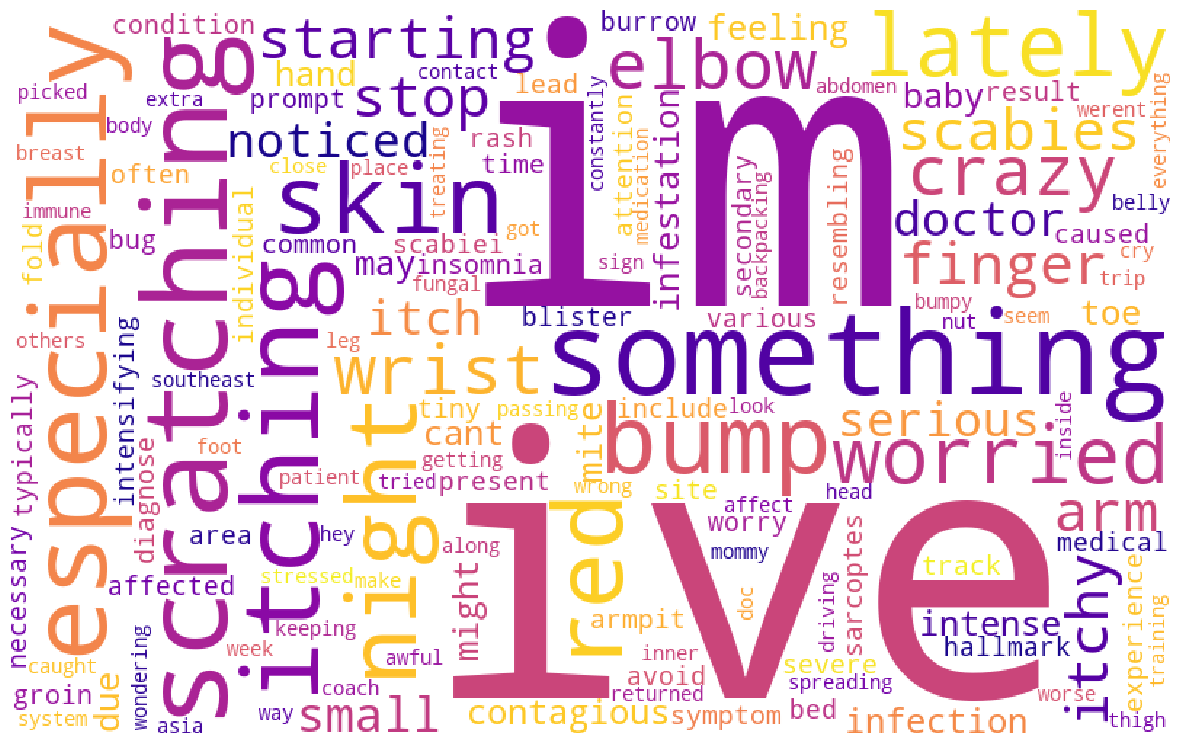

In [332]:
scabies = data_text2.filter(pl.col('disease') == 'scabies')
generate_wordcloud(scabies, 'text')

#### Eczema: Keywords

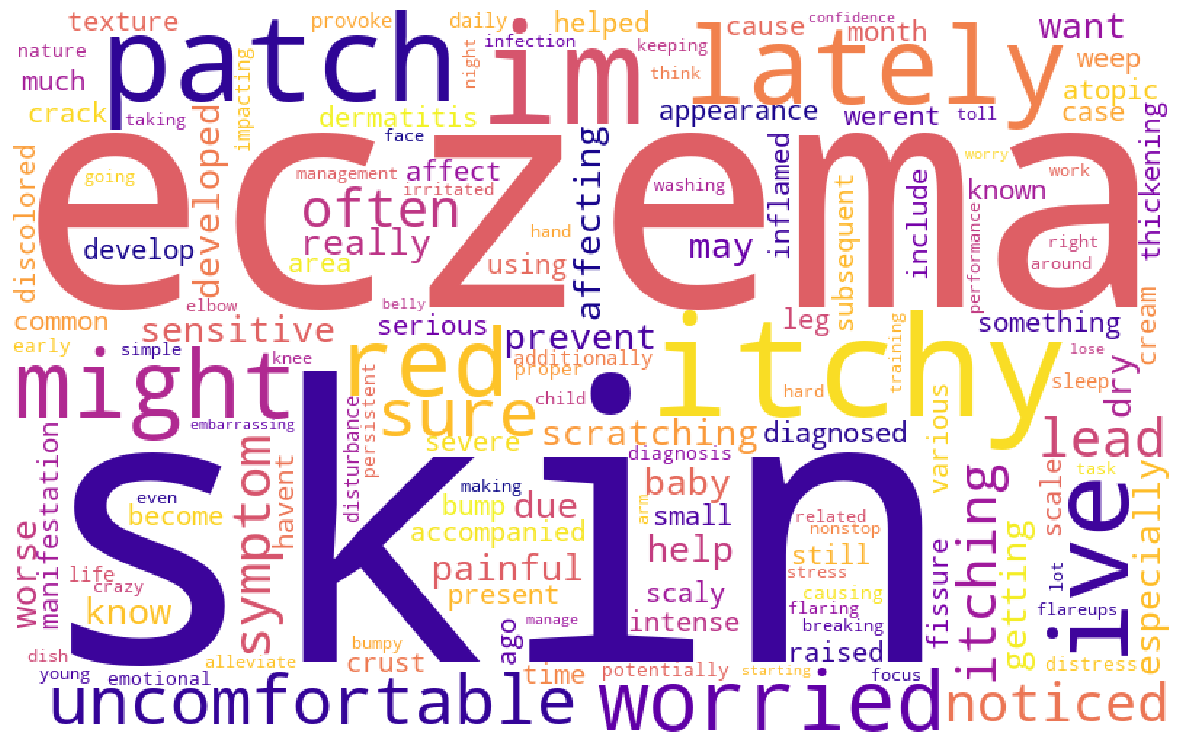

In [333]:
eczema = data_text2.filter(pl.col('disease') == 'eczema')
generate_wordcloud(eczema, 'text')

### Predictive Analytics

#### Vectorization of the Tokens

In [334]:
data_text2 = data_text2.with_columns(
    data_text2['text'] \
        .apply(lambda x: nlp(x).vector) \
            .alias('text'))

#### Split to Train and Test Data

In [335]:
train, test = train_test_split(data_text2, 
                               test_size=0.2, 
                               stratify=data_text2['disease'], 
                               random_state=122)

# check the dimension of the training and test dataset
print('Dimension of training dataset: ', train.shape)
print('Dimension of test dataset: ', test.shape)

Dimension of training dataset:  (114, 2)
Dimension of test dataset:  (29, 2)


In [336]:
# segregate target and features
X_train = train['text']
y_train = train['disease']

X_test = test['text']
y_test = test['disease']

#### Feature Engineering

In [337]:
# initialise scaler and encoder
encoder = LabelEncoder()
scaler = MinMaxScaler()

#### Encode the target variable

In [338]:
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

#### Scale the feature matrices

In [339]:
X_train_array = np.array(X_train)
X_test_array = np.array(X_test)

X_train_2d = np.stack(X_train_array)
X_test_2d = np.stack(X_test_array)

In [340]:
X_train_scaled = scaler.fit_transform(X_train_2d)
X_test_scaled = scaler.transform(X_test_2d)

#### Model Training

In [341]:
lgb_clf = LGBMClassifier(objective='multiclass', 
                         num_class=13, boosting_type='gbdt', 
                         metric='multi_logloss', num_leaves=31, 
                         learning_rate=0.05, feature_fraction=0.9)

In [342]:
lgb_clf.fit(X_train_scaled, y_train_encoded)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


LGBMClassifier(feature_fraction=0.9, learning_rate=0.05, metric='multi_logloss',
               num_class=13, objective='multiclass')

In [343]:
# make prediction
y_pred = lgb_clf.predict(X_test_scaled)

#### Model Evaluation

In [344]:
accuracy = accuracy_score(y_test_encoded, y_pred) * 100
report = classification_report(y_test_encoded, y_pred)

In [345]:
print(f'Accuracy: {accuracy:.2f}%')
print(f'Classification Report:\n\n{report}')

Accuracy: 34.48%
Classification Report:

              precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         2
           4       1.00      0.50      0.67         2
           5       1.00      0.50      0.67         2
           6       0.25      0.33      0.29         3
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         2
           9       0.17      0.50      0.25         2
          10       0.33      0.33      0.33         3
          11       0.50      1.00      0.67         2
          12       0.40      0.67      0.50         3

    accuracy                           0.34        29
   macro avg       0.32      0.33      0.30        29
weighted avg       0.32      0.34      0.31        29



#### Random Forest Classifier

In [346]:
rf_clf = RandomForestClassifier(n_estimators=100, 
                                random_state=122)

In [347]:
rf_clf.fit(X_train_scaled, y_train_encoded)
# make prediction
y_pred = rf_clf.predict(X_test_scaled)
accuracy = accuracy_score(y_test_encoded, y_pred) * 100
report = classification_report(y_test_encoded, y_pred)

In [348]:
print(f'Accuracy: {accuracy:.2f}%')
print(f'Classification Report:\n\n{report}')

Accuracy: 31.03%
Classification Report:

              precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         2
           4       0.33      0.50      0.40         2
           5       1.00      0.50      0.67         2
           6       0.33      0.33      0.33         3
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         2
           9       0.25      0.50      0.33         2
          10       0.50      0.33      0.40         3
          11       0.40      1.00      0.57         2
          12       1.00      0.33      0.50         3

    accuracy                           0.31        29
   macro avg       0.33      0.31      0.28        29
weighted avg       0.36      0.31      0.30        29



- Classes 1, 2, 3, 7, and 8 have zero precision and recall, meaning the model failed to correctly identify any instance of these classes.
- Class 4, 5, and 11 performed relatively well, with high precision and recall. For example, Class 4 has a precision of 1.00 and recall of 0.50.
- Class 9 and 12 have moderate f1-scores, indicating a reasonable balance between precision and recall for these classes.
- The overall accuracy of the model is 0.34, meaning it correctly predicted 34% of all instances across all classes.
- The macro and weighted averages are quite low (around 0.30-0.32), indicating that the model's overall performance across all classes is not very high, with significant room for improvement.